# Replicating  Card and Krueger's 1994 study
# Minimum Wages and Employment: 
## A Case Study of the Fast-Food Industry in New Jersey and Pennsylvania

## Introduction

Study's abstract:

"On April 1, 1992, New Jersey's minimum wage rose from \\$4.25 to \\$5.05 per
hour. To evaluate the impact of the law we surveyed 410 fast-food restaurants in
New Jersey and eastern Pennsylvania before and after the rise. Comparisons of
employment growth at stores in New Jersey and Pennsylvania (where the
minimum wage was constant) provide simple estimates of the effect of the higher
minimum wage. We also compare employment changes at stores in New Jersey
that were initially paying high wages (above \\$5) to the changes at lower-wage
stores. We find no indication that the rise in the minimum wage reduced
employment. "

This paper used the differences-in-differences model  (DiD) to estimate the impact NJ minimum wage on the state's employment of low skill workers in the fastfood sector. The DiD model is designed to estimate causal impact of treatment in a quasi-experimental environment by finding the difference in changes of the treated group and those of a control group. The naive way of handling this estimation is to take the difference of the outcome variable for pre and post-treatment periods for both groups seperately and then take the difference of those differences. 

(treated group post-treatment - treated group pre-treatment) - (control group post-treatment - control pre-treatment)

However, with regression we can estimate the DiD conditioned on other variables to avoid omitted-variable bias that would leave us believing that the causal impact is lessor or greater than it actually is.

$Y_{i,t} = \alpha + \beta_{1}$treated_group$_{i} + \beta_{2}$post_treatment$_{t} + \beta_{3}$treated_group*post_treatment$_{i,t} + \beta_{4}X_{i,t} + e_{i,t}$

with treated_group being a dummy variable indicating the treated group, post_treatment being a dummy indicating the post treatment period, and X being a matrix of control variables. $\beta_{1}$ measures the difference across groups, $\beta_{2}$ measures the difference across periods, and $\beta_{3}$ measures the DiD (our estimated casual impact).

In this notebook, I attempt to replicate the primary tables and visualizations of Card and Krueger's 1994 paper. The paper actually used a slighlty different approach to get the DiD estimation. Their model took the following form:

$Y_{i,t_{1}} - Y_{i,t_{0}} = \alpha + \beta_{1}$treated_group$_{i} + \beta_{2}X_{i,t} + e_{i,t}$

Where the dependent variable is the difference in outcomes between the two periods and the casual effect is measured by $\beta_{1}$. I estimate both models and compare results.

In [1]:
#Importing libraries
import os
import numpy as np
import pandas as pd
import datetime as dt
import math
import statsmodels as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from IPython.display import display
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Removes the limit from the number of displayed columns and rows.
#This is so I can see the entire dataframe when I print it
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

## Data

In [3]:
#Importing dataset
os.chdir(r'C:\Users\dhuds\Downloads')
df = pd.read_excel('CK1994.xlsx') # Data found in excel format at this link: https://www.ssc.wisc.edu/~bhansen/econometrics/
df.sort_values(by='store').head(10)

,store,chain,co_owned,state,southj,centralj,northj,pa1,pa2,shore,ncalls,empft,emppt,nmgrs,wage_st,inctime,firstinc,meals,open,hoursopen,pricesoda,pricefry,priceentree,nregisters,nregisters11,time
169,1,1,0,1,0,1,0,0,0,0,0,16,30,4,4.5,.,0.25,3,7,16,0.93,0.83,0.85,4,3,0
579,1,1,0,1,0,1,0,0,0,0,.,20,40,4,5.05,.,.,2,7,16,1.05,0.79,0.9,4,3,1
170,2,1,0,1,0,1,0,0,0,0,0,10,6,3,4.75,26,0.5,1,7,14,1.06,0.91,0.96,2,2,0
580,2,1,0,1,0,1,0,0,0,0,.,7.5,10,3,5.25,19,0.38,1,7,15,1.05,1.01,0.94,2,2,1
171,3,2,0,1,0,1,0,0,0,0,3,6,13,3,4.25,13,0.25,2,11,10,1.06,0.95,3.09,5,3,0
581,3,2,0,1,0,1,0,0,0,0,2,4,7,3,5.05,26,0.25,1,11,11,1.05,0.94,2.75,5,3,1
582,4,3,0,1,0,1,0,0,0,0,.,5,30,4,5.05,26,0.28,2,8,13.5,1.22,1.37,0.89,6,4,1
172,4,3,0,1,0,1,0,0,0,0,0,10,12,3,4.75,4,0.25,2,9,12.5,1.06,1,2.13,8,4,0
583,5,3,0,1,0,1,0,0,0,0,2,10,30,4,5.15,4,0.18,2,6,17,1.05,0.94,0.94,5,5,1
173,5,3,0,1,0,1,0,0,0,0,0,5,30,4,4.5,13,0.17,1,6,17,0.95,.,2.13,5,4,0


### Data Dictionary for Relevant Variables

- store: Unique store ID.
- chain: id for fastfood chain consisting of 1=Burger King, 2=KFC, 3=Roys, 4=Wendys.
- co_owned: indicator for if the restaurant is company owned opposed to being franchised owned.
- state: indicator for state. 0 = Pennsylvania and 1 = New Jersey.
- southj: indicator for southern New Jersey.
- centralj: indicator for central New Jersey.
- northj: indicatore for northern New Jersey.
- pa1: northeast suburbs of Philadelphia, Pennsylvania.
- pa2: otherwise.
- wage_st: starting wage (dollars per hour).
- time: indicator for post-treatment period.
- empft: the number of full-time workers.
- emppt: the number of part-time workers.
- nmgrs: number of managers and assistant managers
- hoursopen: hours the stor is open.
- pricesoda: Price of medium soda, including tax
- pricefry: Price of small fries, including tax
- priceentree: Price of entrée, including tax
- nregisters: Number of cash registers in store
- nregisters11: Number of registers open at 11am

In [4]:
# Reporting the Unique values 
columns = df.columns
for col in columns:
    print('Unique Values of {} are \n'.format(col),df[col].unique())
    print('*'*100)

Unique Values of store are 
 [ 46  49 506  56  61  62 445 451 455 458 462 468 469 470 474 481 483 487
 488 489 490 493 495 496 499 509 515  37  39  40  41  42  45  47  48  50
  51  57  58  59  60 408 430 432 433 434 435 438 440 441 443 444 446 448
 449 450 454 459 466 471 472 473 475 476 477 478 485 491 492 497 498 501
 503 510 511 514 516 521 522 113 123 135 138 153 181 191 231 236 254 255
 294 306 311 315 335 372   6  14  26  27  30  31  33  36  77  78  81  82
  83  85  89  94 103 112 128 129 131 139 143 144 145 147 148 151 152 157
 161 163 164 165 169 170 187 190 196 197 234 240 241 242 245 259 268 271
 272 274 276 296 299 301 320 321 324 326 330 334 349 354 356 357 371 373
 375 378 381 403 406 407 409   1   2   3   4   5   8   9  10  11  12  13
  15  16  17  18  19  21  22  23  24  28  29  32  34  35  38  63  64  65
  66  67  68  69  70  71  73  75  76  79  80  84  86  87  88  91  92  93
  95  96  97  98  99 101 102 104 105 106 107 108 111 114 115 116 118 119
 120 122 124 125 130 1

### Observations
- The dataset is at the store level. 
- There are four different chains of restaurants in the data.
- Many of the float vars need to be rounded to two decimal places.
- I already see instances of variables having '.' values. I will replace those with NaN values.

After making the changes needed noted above, following variables need to be calculated based on the formulas David and Krueger used:

Full-Time Equivalent Workers = FT Workers + Managers + (0.5) x PT Workers 
Price of a Full Meal = Price of a Soda + Price of Fries + Price of an Entry

In [5]:
def encode_cat_vars(x,columns):
    x = pd.get_dummies(
        x,
        columns=columns)
    return x

In [6]:
df.replace('.',np.nan, inplace=True) # replacing '.' with NaNs
df = df.round(decimals=2) # Rounding variables to 2 decimal places
df = encode_cat_vars(df,columns=['chain']) # Creating dummy vars based on 'chain' var values
# Renaming chain names I got from another version of this dataset at https://docs.google.com/uc?id=10h_5og14wbNHU-lapQaS1W6SBdzI7W6Z&export=download
# I was able to match the chain var with their chain name based on summary table
dct = {'chain_1': 'Burger King', 'chain_2': 'KFC', 'chain_3': 'Roy Rogers', 'chain_4': 'Wendys'} # Dictionary to rename columns to chain names
df.rename(columns=dct,inplace=True)
df.loc[df['state']==0, 'State'] = 'Pennsylvania' # For table and graph uses
df.loc[df['state']==1, 'State'] = 'New Jersey'
df['pricefullmeal'] = df['pricesoda'] + df['pricefry'] + df['priceentree']
df['fte_emp'] = df['empft'] + df['nmgrs'] + 0.5* df['emppt'] # Full-time equivalent employment
df['total_emp'] = df['empft'] + df['nmgrs'] + df['emppt'] # Total employment
df['% FT Employees'] = df['empft']/df['total_emp']*100 # Full-time workers as a percentage of total count of workers

In [7]:
df.isna().sum() # Null values

store               0
co_owned            0
state               0
southj              0
centralj            0
northj              0
pa1                 0
pa2                 0
shore               0
ncalls            249
empft              18
emppt              14
nmgrs              12
wage_st            41
inctime            97
firstinc          123
meals              11
open               11
hoursopen          11
pricesoda          30
pricefry           45
priceentree        36
nregisters         28
nregisters11       39
time                0
Burger King         0
KFC                 0
Roy Rogers          0
Wendys              0
State               0
pricefullmeal      57
fte_emp            26
total_emp          26
% FT Employees     32
dtype: int64

## Replication

The first replication is that of Table Two that reports the means of key variables. I do not have the data on the recruiting bonus.

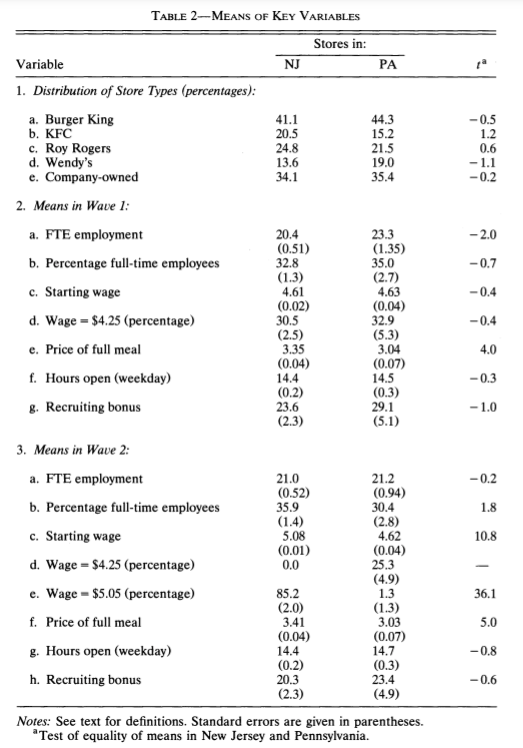

In [8]:
# Indicating stores with starting wages of $4.25 
df.loc[df['wage_st']==4.25, '% at $4.25'] = 100 # 100 instead of 1 to display as % when mean is tabulated
df['% at $4.25'].fillna(0, inplace=True)
# Indicating stores with starting wages of $5.05 
df.loc[df['wage_st']==5.05, '% at $5.05'] = 100
df['% at $5.05'].fillna(0, inplace=True)

In [9]:
# Calculating percentages of bin counts for each state and period combinations
print('Table 2 - Means of Key Variables\n\n')
print('-Distribution of Stores: Percentages-')
print(
    df[['Burger King', 'KFC', 'Roy Rogers', 'Wendys','co_owned','State']].groupby(
        ['State']).agg('mean').round(3).T*100,'\n\n')
print('-Means in Wave 1-')
print(
    df.loc[(df['time']==0), ['fte_emp', '% FT Employees', 'wage_st', '% at $4.25', 'pricefullmeal','hoursopen', 'State']].groupby(
    ['State']).agg(['mean','sem']).round(2).T,'\n\n')
print('-Means in Wave 2-')
print(
    df.loc[(df['time']==1), ['fte_emp', '% FT Employees', 'wage_st', '% at $4.25', '% at $5.05','pricefullmeal','hoursopen', 'State']].groupby(
    ['State']).agg(['mean','sem']).round(2).T)

Table 2 - Means of Key Variables


-Distribution of Stores: Percentages-
State        New Jersey  Pennsylvania
Burger King        41.1          44.3
KFC                20.5          15.2
Roy Rogers         24.8          21.5
Wendys             13.6          19.0
co_owned           34.1          35.4 


-Means in Wave 1-
State                New Jersey  Pennsylvania
fte_emp        mean       20.44         23.33
               sem         0.51          1.35
% FT Employees mean       24.92         26.56
               sem         1.13          2.43
wage_st        mean        4.61          4.63
               sem         0.02          0.04
% at $4.25     mean       30.51         32.91
               sem         2.53          5.32
pricefullmeal  mean        3.35          3.04
               sem         0.04          0.07
hoursopen      mean       14.42         14.53
               sem         0.15          0.33 


-Means in Wave 2-
State                New Jersey  Pennsylvania
fte_emp      

### Observations
- All but the 'Percentage full-time employees' variable was replicated perfectly. I am unsure why the percentage of full time workers is off. I calculated full-time workers divided by the sum of full-time, part-time, and management workers times 100. I tried alternative ways of calculating the metric, but I never found a match to the paper's estimate.


## Wage Charts
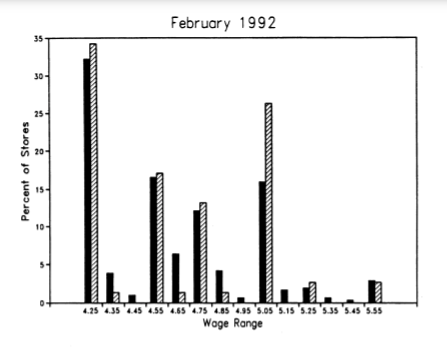

In [10]:
bins = np.arange(4.20,5.7,.1).round(decimals=2).tolist() # Binning groups with binwidth of 10 cents
labels = np.arange(4.25,5.60,.1).round(decimals=2).tolist() # labeling bins as every value ending in .05 as this is logical center for each bin
df['binned_wages'] = pd.cut(df['wage_st'].sort_values(),bins=bins, labels=labels, right=False)
# Accounting for the top bin being open ended to the right
df['binned_wages'] = df['binned_wages'].astype('str') # Converting category to string so that we can edit
df.loc[(df['wage_st']>=5.5),'binned_wages']= '5.55'
df['binned_wages'] = df['binned_wages'].astype('category') # Converting back to category
df['binned_wages'].replace('nan',np.nan, inplace=True) # Replacing string 'nan' values for np.Nan

# Calculating percentages of bin counts for each state and period combinations
count = []
for i in df['binned_wages'].unique():
    for j in df['state'].unique():
        for k in df['time'].unique():
            # percentage = count of wages in bin 'i' for state 'j' in time period 'k'/total for state 'j' and time 'i'*100
            df.loc[(df['binned_wages']==i) & (df['state']==j) & (df['time']==k),'perc'] = df[(df['binned_wages']==i) & (
                df['state']==j) & (df['time']==k)].shape[0]/df[(df['state']==j) & (df['time']==k) & (~df['wage_st'].isna())].shape[0]*100

Text(27.803906250000004, 0.5, 'Percent of Stores')

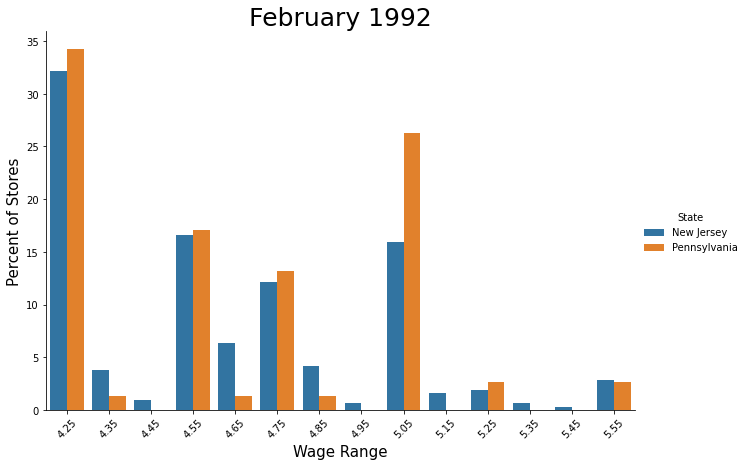

In [11]:

ax=sns.catplot(data=df[df['time']==0], x='binned_wages',y='perc', kind='bar', 
               hue='State', hue_order=['New Jersey','Pennsylvania'], height=6, aspect=1.5)
ax.set_xticklabels(rotation=45, ha="center")
plt.title('February 1992',fontsize=25)
plt.xlabel('Wage Range',fontsize=15) 
plt.ylabel('Percent of Stores',fontsize=15) 

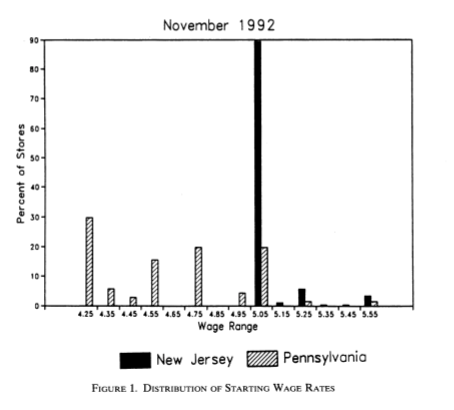

Text(27.803906250000004, 0.5, 'Percent of Stores')

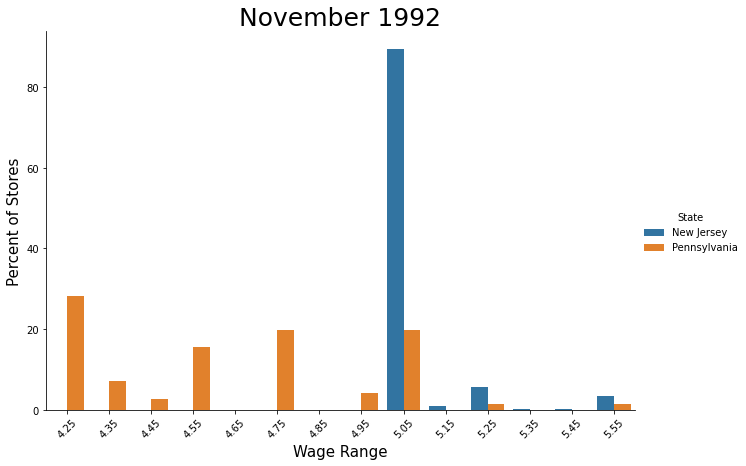

In [12]:
ax=sns.catplot(data=df[df['time']==1], x='binned_wages',y='perc', kind='bar', 
               hue='State', hue_order=['New Jersey','Pennsylvania'], height=6, aspect=1.5)
ax.set_xticklabels(rotation=45, ha="center")
plt.title('November 1992',fontsize=25)
plt.xlabel('Wage Range',fontsize=15) 
plt.ylabel('Percent of Stores',fontsize=15) 

## Replication of Results


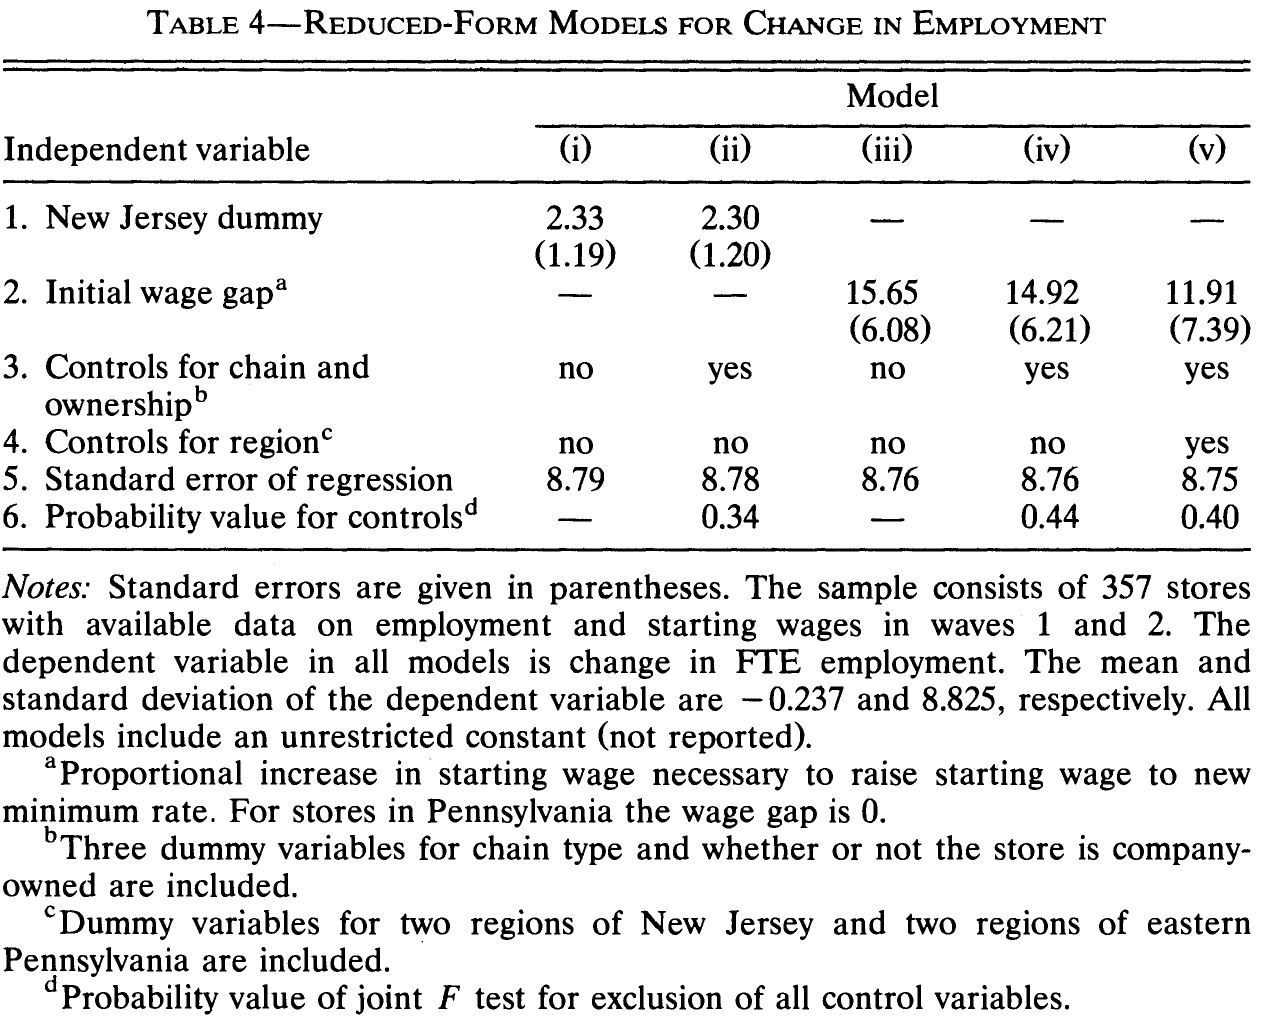

First, the data needs to be limited to only those stores that have both employment and wage data in both periods. The first column shows the estimated treatment effect without any covariates. The second column shows the treatment effect while controlling for the different restaurant chains and whether or not the store is company owned.

In [13]:
# Stores with missing wage or employment data in the first period
store_na = df.loc[((df['wage_st'].isna())|(df['fte_emp'].isna())) & (df['time']==0.0), 'store'].to_list()
# Stores with missing wage or employment data in the second period
store_na2 = df.loc[((df['wage_st'].isna())|(df['fte_emp'].isna())) & (df['time']==1.0), 'store'].to_list()
store_na_list = store_na + store_na2 # Combining lists
df2 = df[~df['store'].isin(store_na_list)] # df excluding the stores with null values for employment and wages

In [14]:
df2['postNJ'] = df2['time']*df2['state'] # Creating interaction variable to estimate causal treatment effect
X = df2[['state','time','postNJ','co_owned','KFC','Roy Rogers','Wendys']] # Explanatory variables
y = df2[['fte_emp']] # Explained variable
print(X.shape)
print(y.shape)

(702, 7)
(702, 1)


In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


def checking_vif(train):
    vif = pd.DataFrame()
    vif["feature"] = train.columns

    # calculating VIF for each feature
    vif["VIF"] = [
        variance_inflation_factor(train.values, i) for i in range(len(train.columns))
    ]
    return vif


# print(checking_vif(x_train))

In [16]:
import statsmodels.api as sm
# Statsmodel api does not add a constant by default. We need to add it explicitly.
X = sm.add_constant(X)


# This function helps streamline the code to build the OLS model
def build_ols_model(ind,dep):
    # Create the model
    olsmodel = sm.OLS(dep, ind)
    return olsmodel.fit(cov_type='HC1')

### First Specification without Covariates

In [17]:
olsmodel1 = build_ols_model(X.loc[:,'const':'postNJ'],y)
print(olsmodel1.summary())

                            OLS Regression Results                            
Dep. Variable:                fte_emp   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.353
Date:                Wed, 19 Jan 2022   Prob (F-statistic):              0.256
Time:                        08:15:39   Log-Likelihood:                -2561.8
No. Observations:                 702   AIC:                             5132.
Df Residuals:                     698   BIC:                             5150.
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.7045      1.513     15.666      0.0

### Observations
- The estimated treatment effect without controlling for any other variables is 2.28 (coefficient for 'postNJ'), very close to Card and Krueger's estimation of 2.33.
- The estimated treatment effect is not statistically significantly different from 0.

### Second Specification with Covariates

In [18]:
olsmodel2 = build_ols_model(X,y)
print(olsmodel2.summary())

                            OLS Regression Results                            
Dep. Variable:                fte_emp   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     48.72
Date:                Wed, 19 Jan 2022   Prob (F-statistic):           2.49e-56
Time:                        08:15:39   Log-Likelihood:                -2478.3
No. Observations:                 702   AIC:                             4973.
Df Residuals:                     694   BIC:                             5009.
Df Model:                           7                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.3896      1.489     17.718      0.0

### Observations
- Controlling for the different chains and company ownership, the estimated treatment effect is 2.28 again, but as a more efficient estimation this time. This is again close to Card and Krueger's estimate of 2.3.

- The estimated treatment effect is not statistically significantly different from 0.

## Alternative Model

- As mentioned earlier, Card and Krueger's model specification actually took the form:

$Y_{i,t_{1}} - Y_{i,t_{0}} = \alpha + \beta_{1}$treated_group$_{i} + \beta_{2}X_{i,t} + e_{i,t}$

The following replicates this models specification.

In [19]:
# Calculating the change in full-time equivalent workers between periods
for i in df2.store.unique():
    df2.loc[(df2.store==i),'empft_diff'] = df2.loc[(df2.store==i) & (df2.time==1), 'fte_emp'].values[0] - df2.loc[(df2.store==i) & (df2.time==0),'fte_emp'].values[0]

In [21]:
# Limiting df to select vars and then collapsing to one observation per store
df4 = df2[['empft_diff','store','KFC','Roy Rogers','Wendys','state','co_owned']].dropna(axis= 0).drop_duplicates()
print('Dataframe shape before collapsing on store: ',df2.shape[0])
df4 = df4[~df4['store'].isin(store_na_list)].sort_values(by='store') # Confirming the stores are the same as in previous models
print('Dataframe shape before collapsing on store: ',df4.shape[0])
X2 = df4[['KFC','Roy Rogers','Wendys','co_owned','state']]
y2 = df4[['empft_diff']]
X2 = sm.add_constant(X2)

Dataframe shape before collapsing on store:  702
Dataframe shape before collapsing on store:  351


### First Specification

In [22]:
olsmodel3 = build_ols_model(X2[['const','state']],y2)
print(olsmodel3.summary())

                            OLS Regression Results                            
Dep. Variable:             empft_diff   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     2.464
Date:                Wed, 19 Jan 2022   Prob (F-statistic):              0.117
Time:                        08:16:41   Log-Likelihood:                -1257.0
No. Observations:                 351   AIC:                             2518.
Df Residuals:                     349   BIC:                             2526.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8788      1.370     -1.372      0.1

### Observations
- The estimated treatment effect is 2.8, just as in the previous models.
- Againt the result is statistically insignificant.

### Second Specifcation with Covariates

In [23]:
olsmodel4 = build_ols_model(X2,y2)
print(olsmodel4.summary())

                            OLS Regression Results                            
Dep. Variable:             empft_diff   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.649
Date:                Wed, 19 Jan 2022   Prob (F-statistic):              0.146
Time:                        08:16:48   Log-Likelihood:                -1255.2
No. Observations:                 351   AIC:                             2522.
Df Residuals:                     345   BIC:                             2546.
Df Model:                           5                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4500      1.671     -0.868      0.3

### Observations
- The estimated treatment effect is still 2.28 after accounting for covariates.
- The result is still statistically insignificant.

# Concluding Statement

Card & Krueger (1994) was replicated with only a few minor deviations from their results. None of the estimated treatment effects were statistically significant. Some words of caution before walking away and thinking that the minimum wage had no effect on employment from this one paper:

- This study's models assumed that stores would only start to react to the minimum wage increase after the policy took effect, rather than when the leglistation passed. Its likely that the stores slowed highering prior to the policy took effect. It is easier and cheaper to slow hiring than to fire workers later on.
- Looking at the full-time equivalent workers in the Table 2, the gap that exists prior to the policy taking effect converged to 21 in both states after the policy. Perhaps, stores in NJ wanted 21 or so FTE workers but were waiting until the policy went into effect to see how costly it would truly be and how much of that cost they could pass onto consumers - supporting the point above.
- This only looked at fastfood workers when there are more industries that employ low skill workers that earn close to the minimum wage.
- It is possible that the increase minimum wage attracted individuals who had material advantages into the market and gained from employment at the expense of those who were less advantaged and lower skilled. For example, teenagers from wealthier backgrounds would likely have a high reservation wage rate before they would be willing to enter the labor market. If the minimum wage was increased above their reservation wage rate and if employers valued them more because they had access to more reliable transportation and had better quality education, then these individuals would be employed in these positions rather than the lower income workers that the policy was aimed at helping.

# References

Card, D., &amp; Krueger, A. (1994). Minimum Wages and Employment: A Case Study of the Fast-Food Industry in New Jersey and Pennsylvania. AER. Retrieved January 19, 2022, from https://davidcard.berkeley.edu/papers/njmin-aer.pdf 

Firey, T. (2019, April 23). No, Krueger Didn't 'Prov[e] that Raising the Minimum Wage Doesn't Increase Unemployment'. Econlib. Retrieved January 19, 2022, from https://www.econlib.org/no-krueger-didnt-prove-that-raising-the-minimum-wage-doesnt-increase-unemployment/ 